In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,BatchNormalization,Dense,GlobalAveragePooling2D

In [ ]:
train_data = '/content/drive/MyDrive/archive dara/Fire-Detection'
print(os.listdir(train_data))

['0', '1']


In [ ]:
# above we can see that fire dataset is marked as 0(No-fire) and 1(Fire) so seperating data into 2 types
train_fire = os.listdir(os.path.join(train_data,'1'))
train_not_fire = os.listdir(os.path.join(train_data,'0'))

In [ ]:
fig_index=0

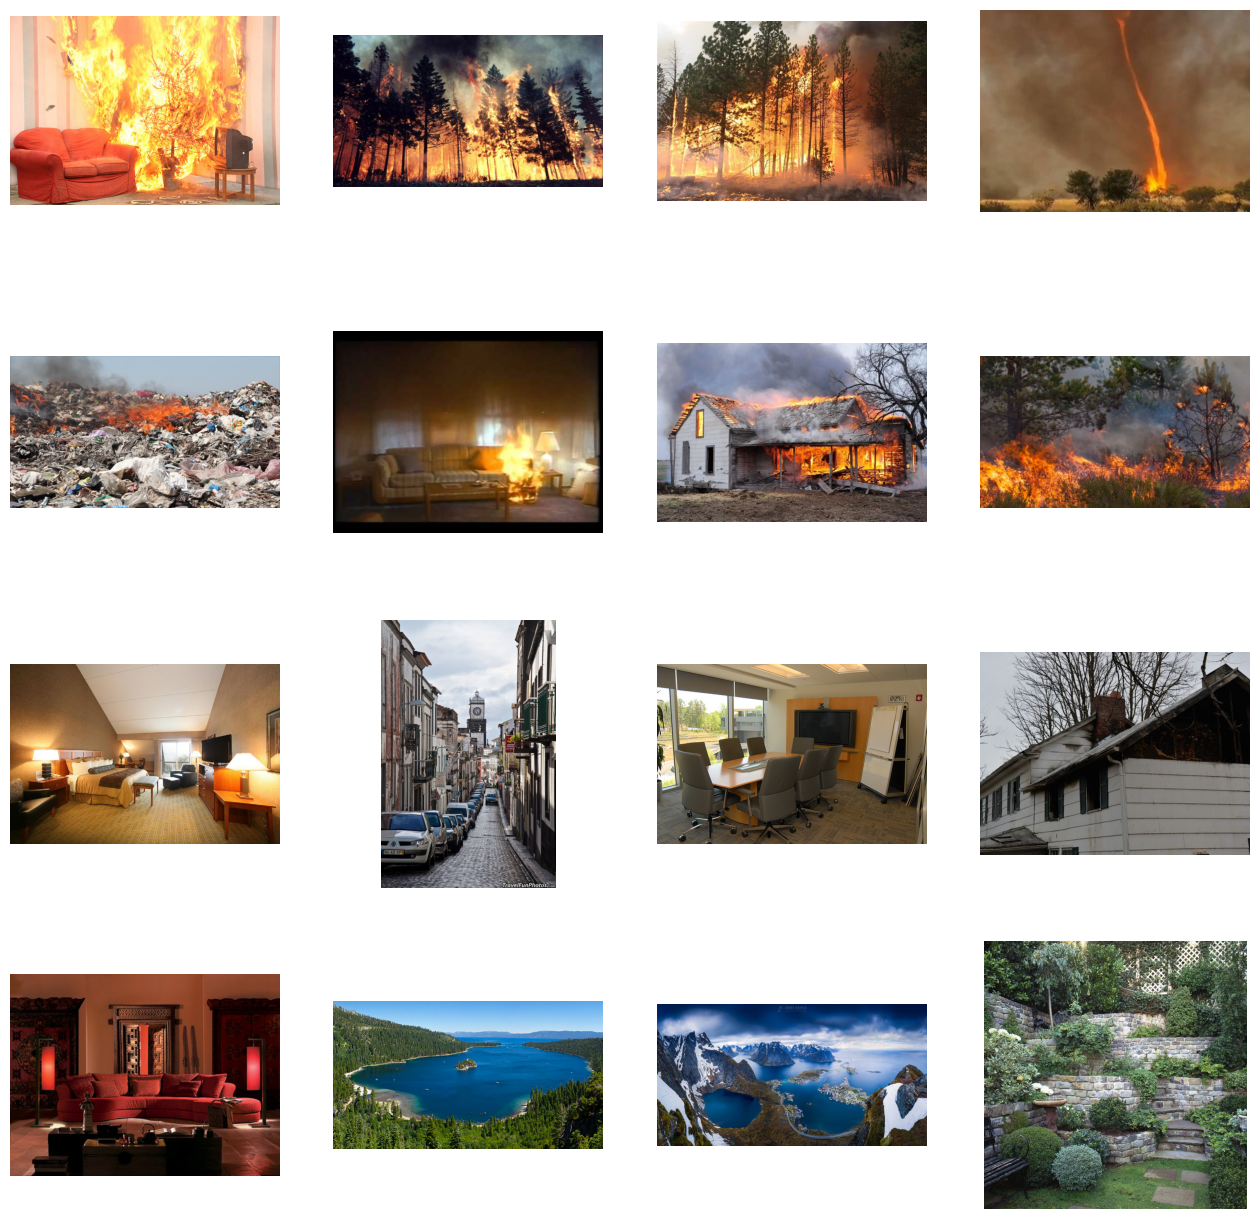

In [ ]:
n_rows = 4
n_cols = 4
# Here we are using gcf to clen the plot if the cell is being runned 2 or more times
fig = plt.gcf()

# Setting the size of each image
fig.set_size_inches(n_rows*4,n_cols*4)

fig_index+=8

# Pulling 8 images from each class to display
fire_8 = [os.path.join(train_data,'1',fname) for fname in train_fire[fig_index-8:fig_index]]
not_fire_8 = [os.path.join(train_data,'0',fname) for fname in train_not_fire[fig_index-8:fig_index]]

# Printing the images from each class, if you notice you will see first 8 images will have fire in them other 8 will not have fire in them
for i,img_path in enumerate(fire_8+not_fire_8):
    sp = plt.subplot(n_rows,n_cols,i+1)
    sp.axis('Off')
    img = mimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [ ]:
train_gen = ImageDataGenerator(width_shift_range = 0.5,
                              height_shift_range = 0.5,
                              validation_split = 0.2)

train_set = train_gen.flow_from_directory(train_data,target_size = (300,300),class_mode = 'binary',subset = 'training',batch_size = 8)

validation_set = train_gen.flow_from_directory(train_data,target_size = (300,300),class_mode = 'binary',subset = 'validation',batch_size = 8)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
pre_trained_resnet_50 = tf.keras.applications.ResNet50(include_top = False,
                                                      input_shape = (300,300,3),
                                                      pooling = 'avg',
                                                      classes = 100,
                                                      weights = 'imagenet')

# Here we want last 10 layers to be trainable so freezing first 40 layers
x = 0
for layer in pre_trained_resnet_50.layers:
    layer.trainable = False
    x+=1
    if x == 39:
        break

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
model = Sequential()
model.add(pre_trained_resnet_50)
model.add(Dense(2048,activation='relu'))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8000,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4000,activation='relu'))
model.add(Dense(2000,activation='relu'))
model.add(Dense(1000,activation='relu'))
model.add(Dense(500,activation='relu'))
model.add(Dense(250,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(1,activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 4096)              8392704   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 8000)              32776000  
                                                                 
 dropout_1 (Dropout)         (None, 8000)              0         
                                                                 
 dense_3 (Dense)             (None, 4000)              3

In [ ]:
callback_lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

# Using tensorflow's Model-Checkpoint to save best model having less validation loss
modelcheck_lr = tf.keras.callbacks.ModelCheckpoint(filepath='/kaggle/working/final_model.h5',monitor='val_loss',save_best_only = True)

# Using Adam's optimizer to optimize our model to better learn on our dataset
model.compile(optimizer = tf.keras.optimizers.Adam() ,loss = 'binary_crossentropy',metrics = 'accuracy')

In [ ]:
model_hist = model.fit(train_set,validation_data = validation_set,epochs = 100,callbacks = [callback_lr,modelcheck_lr])

Epoch 1/100
20/20 [==============================] - 125s 4s/step - loss: 0.7016 - accuracy: 0.4563 - val_loss: 0.6925 - val_accuracy: 0.4250 - lr: 1.0000e-08
Epoch 2/100
20/20 [==============================] - 9s 436ms/step - loss: 0.7008 - accuracy: 0.4500 - val_loss: 0.6951 - val_accuracy: 0.4500 - lr: 1.1220e-08
Epoch 3/100
20/20 [==============================] - 10s 526ms/step - loss: 0.7014 - accuracy: 0.4500 - val_loss: 0.6969 - val_accuracy: 0.4250 - lr: 1.2589e-08
Epoch 4/100
20/20 [==============================] - 10s 516ms/step - loss: 0.7024 - accuracy: 0.4500 - val_loss: 0.6970 - val_accuracy: 0.4250 - lr: 1.4125e-08
Epoch 5/100
20/20 [==============================] - 9s 436ms/step - loss: 0.7003 - accuracy: 0.4313 - val_loss: 0.6961 - val_accuracy: 0.4000 - lr: 1.5849e-08
Epoch 6/100
20/20 [==============================] - 12s 611ms/step - loss: 0.6966 - accuracy: 0.4500 - val_loss: 0.6943 - val_accuracy: 0.4500 - lr: 1.7783e-08
Epoch 7/100
20/20 [===================

(1e-08, 0.001, 0.0, 1.0)

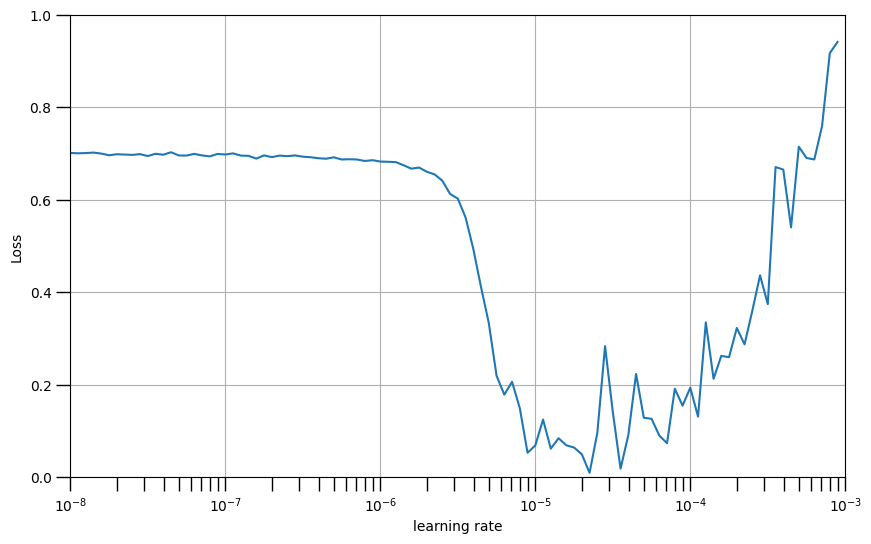

In [ ]:
# Creating graph to visualzie how our model performed at different learning rate and its loss.
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)
plt.xlabel("learning rate")
plt.ylabel("Loss")
# Plot the loss in log scale
plt.semilogx(lrs, model_hist.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 1])

In [ ]:
# Downloading our best model that was picked up by Model-Checkpoint
best_model = tf.keras.models.load_model('/kaggle/working/final_model.h5')

# now checking the final evalutaion of our model
best_model.evaluate(validation_set)

5/5 [==============================] - 4s 645ms/step - loss: 0.0569 - accuracy: 0.9750


[0.05688248947262764, 0.9750000238418579]

In [ ]:
# Funtion to read image and transform image to tensor
def load_and_prep_image(filename, img_shape = 300):
    img = tf.io.read_file(filename) #read image
    img = tf.image.decode_image(img) # decode the image to a tensor
    img = tf.image.resize(img, size = [img_shape, img_shape]) # resize the image
    return img

In [ ]:
# Funtion to read image and give desired output with image
def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    if len(pred[0]) > 1: # check for multi-class
        pred_class = class_names[pred.argmax()] # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

    # Plot the image and predicted class
    sh_image = plt.imread(filename)
    plt.imshow(sh_image)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)

1/1 [==============================] - 2s 2s/step


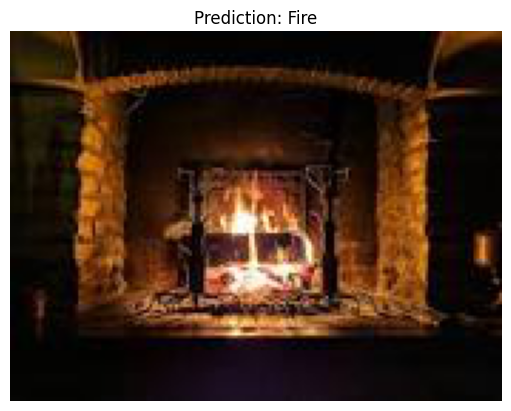

In [ ]:
sample_img = '/download.jpg'

# predefining class names so not to confuse with the output
class_names = ['Not-fire','Fire']

# reading the input and checking the output
pred_and_plot(best_model,sample_img,class_names)